# Artificial Neural Network implementation
Python implementation of the ANN (artificial neural network) architecture.

This code is aimed to be for educational purposes.

This Jupyter Notebook provides a Python implementation of an artificial neural network (ANN) architecture. The purpose of this implementation is to serve as an educational resource for anyone interested in understanding how ANNs work and how they can be implemented in Python, taking into account the specific parts in which I struggled.

The implementation includes the necessary components for building a feedforward neural network, including input, hidden, and output layers. The network is trained using the backpropagation algorithm with stochastic gradient descent.

The implementation also includes a range of options for customizing the network, including the number of layers, the number of neurons in each layer, the activation function used for each neuron, and the learning rate used in the backpropagation algorithm.

Overall, this Jupyter Notebook provides a comprehensive and customizable implementation of an ANN architecture that can be used to develop a better understanding of how ANNs work and how they can be applied in a wide range of contexts.

# Setup

In [1]:
import math
import numpy as np
import torch
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

# Derivatives
I am building the derivative mathematical object, not in a symbolic manner but using an analytical approach, answering the question: how does the function respond to a little movement on the x-axis (for one input function) called $h$?

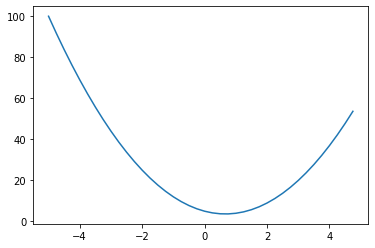

In [2]:
f = lambda x: 3*(x**2) - 4*x + 5
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

In [3]:
h = 1e-4
x = 3.0

print(f'f({x}) = {f(x)}')
print(f'f({x} + {h}) = {f(x + h)}')

f(3.0) = 20.0
f(3.0 + 0.0001) = 20.001400030000006


To converge to the **real** derivative $h$ has to be minimized, taking care of not occurring in numerical approximations problems while dealing with FPs.

In [4]:
h = 1e-4

unnormalized_slope = f(x+h) - f(x)
print(f'Unnormalized slope of f(x) (x = {x}) = {unnormalized_slope}')

derivative = unnormalized_slope / h
print(f'Derivative of f(x) (x = {x}) = {derivative}')

Unnormalized slope of f(x) (x = 3.0) = 0.0014000300000063248
Derivative of f(x) (x = 3.0) = 14.000300000063248


## Using multi-variable functions
Multi-variable methods have one dependent variable and more than one independent variable. Do not confuse them with multivariate functions, which in turn have many dependent variables. 

In [5]:
h = 1e-4

a = 2.0
b = -3.0
c = 10.0
d = lambda a,b,c: a*b + c

d_value =  d(a, b, c)

print('Derivative of d(a, b, c) w.r.t. a =', (d(a+h, b, c) - d_value)/h)
print('Derivative of d(a, b, c) w.r.t. b =', (d(a, b+h, c) - d_value)/h)
print('Derivative of d(a, b, c) w.r.t. c =', (d(a, b, c+h) - d_value)/h)

Derivative of d(a, b, c) w.r.t. a = -3.000000000010772
Derivative of d(a, b, c) w.r.t. b = 2.0000000000042206
Derivative of d(a, b, c) w.r.t. c = 0.9999999999976694


# Define simple math expressions
The following is the definition of a Value, which is used to formulate complex math expressions through the concatenation of Values (i.e., atoms).

In [6]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        return Value(np.tanh(self.data), (self, ), 'tanh')
    
    def __repr__(self):
        return f'Value(label = {self.label} | data = {self.data} | grad = {self.grad})'

## Chained math expression
$$L = ((a \cdot b) + c) \cdot f$$

In [7]:
def create_expr():
    a = Value(2.0, label = 'a'); a.grad = 6
    b = Value(-3.0, label = 'b'); b.grad = -4
    c = Value(10.0, label = 'c'); c.grad = -2.0
    e = a * b; e.label = 'e'; e.grad = -2.0
    d = e + c; d.label = 'd';  d.grad = -2.0
    f = Value(-2.0); f.label = 'f'; f.grad = 4.0
    L = d * f; L.label = 'L'; L.grad = 1.0
    return L

Let's define a function to print the **computational graph** out of the math expression.

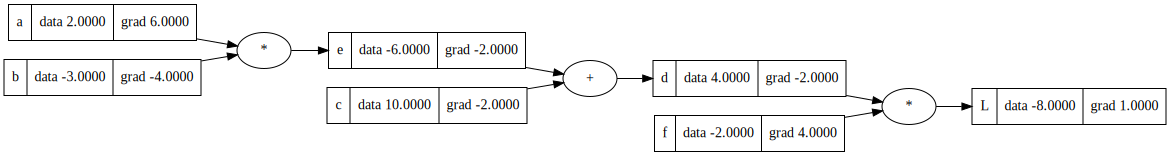

In [8]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(create_expr())

# Derivative calculus
I am interested in the derivative of the final node (i.e., loss function) w.r.t. the leaf nodes.

The baseline derivative (i.e. derivative $L$ w.r.t. itself):
$$\frac{dL}{dL} = 1$$

In [9]:
def baseline_derivative(h: int = 1e-6):
    expr_value = create_expr().data
    baseline_derivative = (expr_value + h - expr_value) / h
    print('Baseline derivative of L = %.4f' % (baseline_derivative))

baseline_derivative()

Baseline derivative of L = 1.0000


What happens when the derivative of $L$ is computed w.r.t. the local nodes (the ones in the layer immediately before)? 

For the node $f$:
$$\frac{dL}{df} = \frac{d(d \cdot f)}{df} = \frac{(d \cdot (f + h)) - (d \cdot f)}{h} = \frac{df + dh - df}{h} = \frac{dh}{h} = d$$

For the node $d$:
$$\frac{dL}{dd} = \frac{d(d \cdot f)}{dd} = \frac{((d + h) \cdot f) - (d \cdot f)}{h} = \frac{df + fh - df}{h} = \frac{fh}{h} = f$$

In [10]:
def derivative_L_wrt_d(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        d.data += h
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node d = %.4f' % (derivative))

derivative_L_wrt_d()

Derivative of L w.r.t. leaf node d = -2.0000


Now, how can I derive a non-local derivative? In other words, how can I compute the derivative of $L$ w.r.t. the non-local nodes ($c$, $e$, $a$, and $b$)? 

To compute how $c$ affects $L$ - besides calculating the derivative of $L$ w.r.t. $d$ - compute how $d$ is sensitive to $c$ and link the two components somehow. Let's proceed with the calculus of the local derivative(s):

$$\frac{dd}{dc} = \frac{d(c + e)}{dc} = \frac{((c + h) + e) - (c + e)}{h} = \frac{h}{h} = 1$$

Similarly, compute the local derivative of $d$ w.r.t. $e$:

$$\frac{dd}{de} = \frac{d(c + e)}{de} = \frac{(c + (e + h)) - (c + e)}{h} = \frac{h}{h} = 1$$

Finally, use the chain rule for computing $\frac{dL}{dc}$ and $\frac{dL}{de}$:
$$\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}$$

$$\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de}$$

In [11]:
def derivative_L_wrt_e(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        e.data += h
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node e = %.4f' % (derivative))

derivative_L_wrt_e()

Derivative of L w.r.t. leaf node e = -2.0000


In [12]:
def derivative_L_wrt_c(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        c.data += h
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node c = %.4f' % (derivative))

derivative_L_wrt_c()

Derivative of L w.r.t. leaf node c = -2.0000


In the same way, I use the chain rule for computing $\frac{dL}{da}$ and $\frac{dL}{db}$:

$$\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da}$$

$$\frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{db}$$

The reason why above I did not write $\frac{dL}{da} = \frac{dL}{dd} \cdot \frac{dd}{de} \cdot \frac{de}{da}$ is that $\frac{dL}{dd}$ is somehow **incapsulated** inside $\frac{dL}{de}$. The same applies for the derivative w.r.t. $b$.

In [13]:
def derivative_L_wrt_b(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        b.data += h
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node b = %.4f' % (derivative))
    
def derivative_L_wrt_a(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        a.data += h
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node a = %.4f' % (derivative))

derivative_L_wrt_a()
derivative_L_wrt_b()

Derivative of L w.r.t. leaf node a = 6.0000
Derivative of L w.r.t. leaf node b = -4.0000


# Back-propagation 
Once I have computed the gradient for each of the nodes in the graph, I can adjust their value according to the gradient of the final value w.r.t. them.

I will use a 2-dimensional single-neuron as an example.

In [14]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# Weights (synamptic strenght)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.881373587019, label = 'b')

# Linear combination btw inputs and weights
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation function
out = n.tanh(); out.label = 'out'

## Manually computing the derivative of the output w.r.t. the weights

As aforementioned, use the chain rule to compute the derivatives of the output w.r.t. the weights in the network:

$$\frac{do}{do} = \frac{d{tanh(n)}}{d{tanh(n)}} = 1$$

$$\frac{do}{dn} = \frac{tanh(n)}{dn} = \frac{tanh(n+h) - tanh(n)}{h} = 0.5$$

$$\frac{do}{db} = \frac{do}{dn} \cdot \frac{dn}{db} = 0.5 \cdot \frac{(x1 \cdot w1 + x2 \cdot w2 + (b + h)) - (x1 \cdot w1 + x2 \cdot w2 + b)}{h} = 0.5 \cdot 1 = 0.5$$

$$\frac{do}{d{w_1}} = \frac{do}{d{x_1}{w_1}} \cdot \frac{d{x_1}{w_1}}{d{w_1}} = 0.5 \cdot = 0.5 \cdot \frac{x_1 \cdot (w_1 + h) - x_1 \cdot w_1}{h} = 1$$

Intuetively, the derivative of $w_2 = 0$, since $x_2 = 0$, $w_2$ has zero impact on the output.

$$\frac{do}{d{w_2}} = \frac{do}{d{x_2}{w_2}} \cdot \frac{d{x_2}{w_2}}{d{w_2}} = 0.5 \cdot = 0.5 \cdot \frac{x_2 \cdot (w_2 + h) - x_2 \cdot w_2}{h} = \frac{x_2w_2 + x_2h - x_2w_2}{h} = \frac{x_2h}{h} = x_2 = 0$$

Just for the sake of comprehension, I hard-code the gradients inside the nodes.

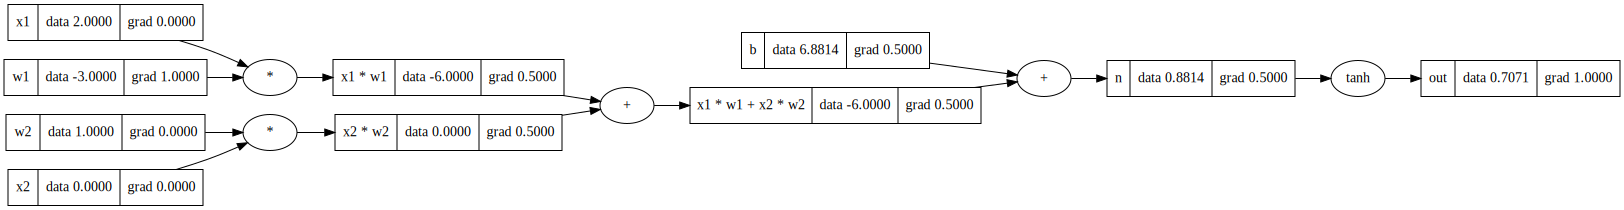

In [15]:
out.grad = 1.0
n.grad = 0.5
b.grad = 0.5

# These three gradients flows backward through the network
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

# These have to be computed with the chain rule
w1.grad = 1.0
w2.grad = 0

draw_dot(out)

## Automatic backward pass
Everything stated before is useful to acknowledge the underlying concepts. In real life, it is always needed to implement backpropagation automatically.

Therefore, I use the previously introduced code (`Value` class), adding the `_backward()` methods inside each operation, by which the gradient flows from `out.grad` to `self.grad`, i.e., propagates from the current node to the children nodes. If one of the children is a leaf node, its `_backward()` always returns `None`, since it was never initialized with an operation between other nodes.

In [16]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        # For an addition operation, the gradient "flows" w/o any modifications
        def _backward():
            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        # For a multiplication operation, the gradient corresponds to the other term involved in the mul op
        def _backward():
            self.grad = other.data * out.grad 
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out
    
    def tanh(self):
        tanh_value = np.tanh(self.data)
        out = Value(tanh_value, (self, ), 'tanh')
        
         # Applying the tanh function, the gradient corresponds to the following
        def _backward():
            self.grad = (1-tanh_value**2) * out.grad
            
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f'Value(label = {self.label} | data = {self.data} | grad = {self.grad})'

We could definitely call the method `backward()` on top of all elements which have at least one child node that can receive the propagated gradient, all nodes but $w_1$, $w_2$, and $b$.

### Build the topological graph
To avoid calling the `backward()` method on every node, I run the topological sort algorithm of the computational graph, in which we add a node only when all its children have been inserted in the list, i.e., fewer dependent nodes first.

Once the topologically ordered list of nodes is computed, I can more comfortably call backward on its reverse, since the **gradient** must flow from the most dependent node (output) to the fewer dependent ones.
![topological-graph](./images/topological_graph.png)

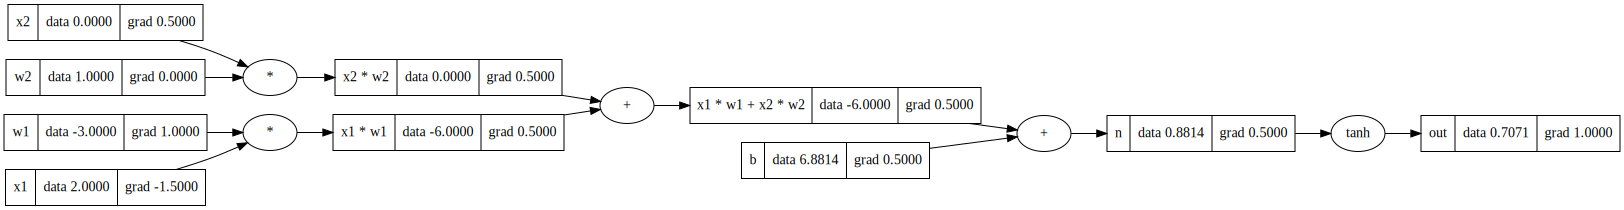

In [17]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# Weights (synamptic strenght)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.881373587019, label = 'b')

# Linear combination btw inputs and weights
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# Activation function
out = n.tanh(); out.label = 'out'

# Topological sorting
topo_order = []
visited_nodes = set()
def build_topo(v):
    if v not in visited_nodes:
        visited_nodes.add(v)
        for child in v._prev:
            build_topo(child)
        topo_order.append(v)
build_topo(out)

# Backward pass
out.grad = 1.0
for node in reversed(topo_order):
    node._backward()

# Draw graph
draw_dot(out)

Moreover, what happens when a child is used more than once as input to other nodes? In that case, I have to use the multi-variable version of the chain rule, where the gradient is accumulated for each node: this kind of node has to account for as many gradient updates as how many output connections it has.

Finally, the following is the final version of the class `Value`, in which there is a `backward()` method and a couple of extra operators have been added.

In [18]:
class Value:
    def __init__(self, data, _children = (), _op = '', label='node'):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        
    def preprocess_other(self, other):
        return other if isinstance(other, Value) else Value(other)
    
    def __add__(self, other):
        other = self.preprocess_other(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # For an addition operation, the gradient "flows" w/o any modifications
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __neg__(self, other):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = self.preprocess_other(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # For a multiplication operation, the gradient corresponds to the other term involved in the mul op
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Please ensure the exponent is either an int or a float.'
        pow_value = self.data ** other
        out = Value(pow_value, (self, ), f'**{other}')
        
         # Applying the pow function, the gradient corresponds to the following
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def tanh(self):
        tanh_value = np.tanh(self.data)
        out = Value(tanh_value, (self, ), 'tanh')
        
         # Applying the tanh function, the gradient corresponds to the following
        def _backward():
            self.grad += (1-tanh_value**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self, other):
        exp_value = math.exp(self.data)
        out = Value(exp_value, (self, ), 'exp')
        
         # Applying the exp function, the gradient corresponds to the following
        def _backward():
            self.grad += exp_value * out.grad
            
        out._backward = _backward
        return out
        
    
    def backward(self):
        # Topological sorting
        topo_order = []
        visited_nodes = set()
        
        def build_topo(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_order.append(v)
        build_topo(self)

        # Backward pass
        self.grad = 1.0
        for node in reversed(topo_order):
            node._backward()
    
    def __repr__(self):
        return f'Value(label = {self.label} | data = {self.data} | grad = {self.grad})'

Now I can call `backward()` just on the final node.

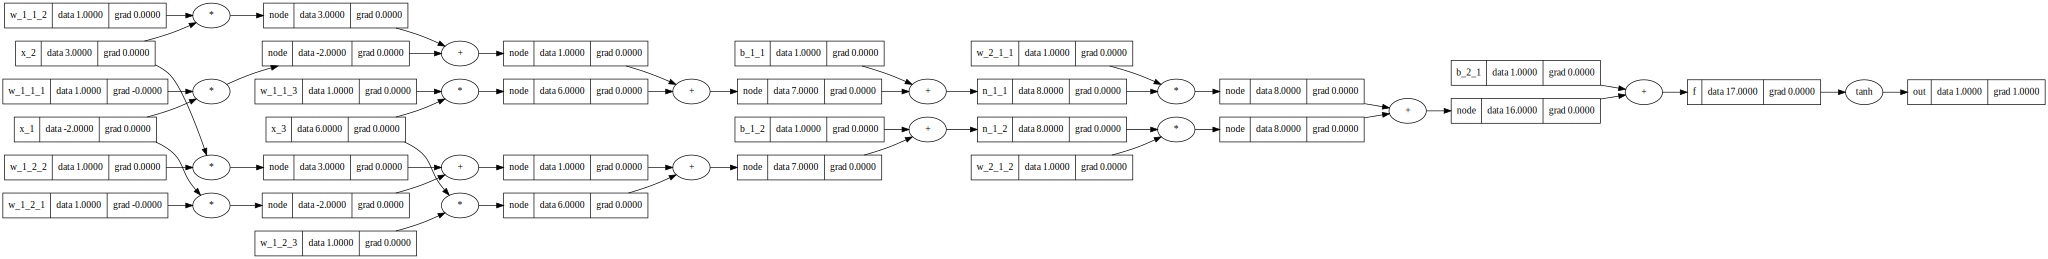

In [19]:
# Inputs
x_1 = Value(-2.0, label = 'x_1')
x_2 = Value(3.0, label = 'x_2')
x_3 = Value(6.0, label = 'x_3')

# First number = layer | Second number = neuron | Third number = input value
# Weights - hidden dense layer
# First neuron
w_1_1_1 = Value(1.0, label = 'w_1_1_1')
w_1_1_2 = Value(1.0, label = 'w_1_1_2')
w_1_1_3 = Value(1.0, label = 'w_1_1_3')
b_1_1 = Value(1.0, label = 'b_1_1')
n_1_1 = x_1 * w_1_1_1 + x_2 * w_1_1_2 + x_3 * w_1_1_3 + b_1_1; n_1_1.label = 'n_1_1'
# Second neuron
w_1_2_1 = Value(1.0, label = 'w_1_2_1')
w_1_2_2 = Value(1.0, label = 'w_1_2_2')
w_1_2_3 = Value(1.0, label = 'w_1_2_3')
b_1_2 = Value(1.0, label = 'b_1_2')
n_1_2 = x_1 * w_1_2_1 + x_2 * w_1_2_2 + x_3 * w_1_2_3 + b_1_2; n_1_2.label = 'n_1_2'

# Weights - output dense layer
# Output neuron
w_2_1_1 = Value(1.0, label = 'w_2_1_1')
w_2_1_2 = Value(1.0, label = 'w_2_1_2')
b_2_1 = Value(1.0, label = 'b_2_1')
f = n_1_1 * w_2_1_1 + n_1_2 * w_2_1_2 + b_2_1; f.label = 'f'
out = f.tanh(); out.label = 'out'

# Backward pass
out.backward()

# Draw graph
draw_dot(out)

Takeaway message? The backward update can be done at a different level of abstraction. For example, `tanh` can be seen as an atom, and its derivative would immediately become $1-(tanh(x))^2$. Alternatively, `tanh` can be broken down into different pieces ($\frac{e^{2x} - 1}{e^{2x} + 1}$), and it would be possible to compute the derivative for each of them.

# PyTorch comparison
Let's use PyTorch APIs for implementing the same network.

Notes:
1. by default, Python use `float64` for FP arithmetic. Instead, **PyTorch** uses `float32`. I use the method `double()` to cast the values.
2. by default, **PyTorch** set `requires_grad = False` for efficiency reasons.

In [20]:
x1 = torch.Tensor([2.0]).double();              x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();              x2.requires_grad = True
#x3 = torch.Tensor([2.0]).double();             x3.requires_grad = True

w1 = torch.Tensor([-3.0]).double();             w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();              w2.requires_grad = True
b = torch.Tensor([6.881373587019]).double();    b.requires_grad = True

n = x1*w1 + x2*w2 + b
out = torch.tanh(n)

print(f'Net output: {out.data}')
out.backward()

print('\n----GRADS AFTER BACKWARD PASS----')
print('w1 =', w1.grad)
print('w2 =', w2.grad)
print('b =', b.grad)

Net output: tensor([0.7071], dtype=torch.float64)

----GRADS AFTER BACKWARD PASS----
w1 = tensor([1.0000], dtype=torch.float64)
w2 = tensor([0.], dtype=torch.float64)
b = tensor([0.5000], dtype=torch.float64)


# Multi-layer perceptrons
Now, let's concentrate on **Multi-layer perceptrons**.